### GIZ Initial Data Exploration
#### author: Emily Robitschek

Purpose: Before we build any model, we need to be able to take a look at the documents we have.

Some resources: 

#### papers mentioned in project proposal: 
https://medium.com/fiscalnoteworthy/citing-your-sources-79062248f468
https://www2.deloitte.com/us/en/insights/focus/cognitive-technologies/natural-language-processing-examples-in-government-data.html
https://documents1.worldbank.org/curated/en/634591516387264234/pdf/WPS8310.pdf

#### NLP related links: 
- https://spacy.io/usage/spacy-101
- https://towardsdatascience.com/text-pre-processing-stop-words-removal-using-different-libraries-f20bac19929a
- https://arunm8489.medium.com/getting-started-with-natural-language-processing-6e593e349675
- https://towardsdatascience.com/natural-language-processing-pipeline-decoded-f97a4da5dbb7

### Import libraries

In [1]:
import os
import glob
import time

import scipy
import numpy as np
import pandas as pd

#set up packages for NLP analysis
import contractions
import nltk
#nltk.download('punkt') 
#nltk.download('stopwords') #had to also download this
import spacy
nlp=spacy.load('en_core_web_sm') #or the multi-language one: spacy.load('xx_ent_wiki_sm')

### Define helper functions for preprocessing

In [2]:
#input data helper functions
def list_docs(folder):
    """Generates a list of document names for reference and tracking. 
    This command currently extracts the .txt documents from all the subfolders of a parent folder, 
    and filters out the ones containing source information, which we might not want to use in our analysis."""
    doc_names = []
    doc_paths = []
    for root, dirs, files in os.walk(folder):
        for file in files:
            if file.endswith('.txt') and (file not in ['Source.txt', 'Source Link.txt', 'Source Links.txt']):
                doc_names.append(file)
                doc_paths.append(os.path.join(root, file))  
    return doc_names, doc_paths


#NLP related helper functions
#used these resources: 
#https://www.geeksforgeeks.org/nlp-expand-contractions-in-text-processing/)
#https://realpython.com/natural-language-processing-spacy-python/#how-to-download-models-and-data

def fix_contractions(document): 
    """Switches contractions like can't to cannot so potentially important words/pieces of words are 
    removed with punctuation removal."""
    # original contracted text
    text = open(document).read()
    
    #creating an empty list
    expanded_words = []    
    for word in text.split():
        #using contractions.fix to expand the shortened words 
        expanded_words.append(contractions.fix(word))   

    expanded_text = ' '.join(expanded_words)
    print('Original text: ', len(text))
    print('Expanded_text: ', len(expanded_text))
    return expanded_text

def is_token_allowed(token):
    '''
        Only allow valid tokens which are not stop words
        and punctuation symbols.
    '''
    if (not token or not token.text.strip() or
        token.is_stop or token.is_punct):
        return False
    return True

def preprocess_token(token):
    # Reduce token to its lowercase lemma form
    return token.lemma_.strip().lower()

### Import data

In [3]:
#keywords (just for testing purposes - from the policy proposal from GIZ)
#eventually want to import a file with keywords
policy = ["policy", "integrate", "implement", "committee", "consultation"]
food = ["nutritions", "diets", "farm", "agriculture", "ecology"]
ndc_national_adaption_plan = ["nap", "sector plan", "nccrp", "vulnerable sector", 
                              "geographic vulnerability"]
ndc_climate_change = ["adaption", "program", "projects", "resilience", "institution",
                      "capacity", "response", "budget", "reprioritisation", "development", 
                      "planner", "regulator", "practitioners", "geographical", 
                      "circumstances", "land", "scheme", "authorisation", "system", 
                      "spluma"]
ndc_early_warning = ["system", "vulnerability", "needs", "assessment", "network", "weather",
   "earth", "observation", "academic", "community"]

In [4]:
#here is the general folder with the different types of policy documents
policy_doc_folder = '/Users/emilyrobitschek/git/giz-policy_tracking_docs/SouthAfrica/Data' #ultimately need to remove this path
policy_doc_names, policy_doc_paths = list_docs(policy_doc_folder)
print("Some of the policy docs include: ", policy_doc_names[:10])

#If want to preserve names and paths of the documents and make them easily searchable, 
#it might be useful to make a dictionary (this could also easily be converted to a dataframe 
#to add more summary information about the document for instance)

policy_doc_dict = {'policy_doc_names': policy_doc_names, 'policy_doc_paths': policy_doc_paths}
policy_doc_df = pd.DataFrame(data=policy_doc_dict, dtype='string')
policy_doc_df.index = policy_doc_df['policy_doc_names']
policy_doc_df.head()

##lets take a look at the document from South Africa used in the example in the proposal first:
test_doc_name = '2nd National Biodiversity Strategy Action Plan 2015-2025.pdf_ocr.txt'
##lets try with another document
test_doc_name = 'InSessionSpecialEditionBudget2021.pdf.ocr.txt'
test_doc_path = policy_doc_df.loc[test_doc_name]['policy_doc_paths']

Some of the policy docs include:  ['InSessionSpecialEditionBudget2021.pdf.ocr.txt', 'InSessionVol2Issue10.pdf.ocr.txt', 'InSessionSpecialEditionBudget2021.txt', 'InSessionVol2Issue10.txt', 'InSessionVol2Issue11.txt', 'InSessionSpecialEdition2021.txt', 'InSessionSpecialEdition2021.pdf.ocr.txt', 'InSessionVol2Issue11.pdf.ocr.txt', '2nd National Biodiversity Strategy Action Plan 2015-2025.pdf_ocr.txt', 'Climate_Change_Bill (2018).txt']


### Preprocess data

In [13]:
#remove contracted words and tokenize the document
expanded_text_doc = nlp(fix_contractions(test_doc_path))

#extract list of word tokens
tokens = [token for token in expanded_text_doc]
print('These are some of the unfiltered tokens: ', tokens[0:50], '\n')

#find sentences
sentences = list(expanded_text_doc.sents)
for sentence in sentences[:10]:
    print(sentence)

Original text:  43521
Expanded_text:  42826
These are some of the unfiltered tokens:  [Oo, Official, newspaper, of, the, Parliament, of, the, Republic, of, South, Africa, @, Special, budget, edition, IMSeSS, ©, ), PARLIAMENT, OF, THE, REPUBLIC, OF, SOUTH, AFRICA, Following, up, on, our, commitments, :, Making, our, future, work, better, Zee, INSESSION, NEWS, The, Bills, are, :, 1, ., 2021, Appropriation, Bill, 2] 

Oo Official newspaper of the Parliament of the Republic of South Africa @ Special budget edition IMSeSS ©) PARLIAMENT OF THE REPUBLIC OF SOUTH AFRICA
Following up on our commitments: Making our future work better Zee INSESSION NEWS
The Bills are: 1. 2021
Appropriation Bill 2.
2021 Special Appropriation Bill 3. 2021 Division of Revenue Bill 4.
The Budget Review 5.
The Estimates of National Expenditure (ENE)
Last year, the Minister said, the government had outlined a strategy for South Africa to become a winning country, and since then the government has mourned the passing of

#### The token object: 
The tokens have all sorts of useful information association with them, for instance their positions (in token.idx) which we can use these later to define windows. See below for example.

In [14]:
for token in expanded_text_doc[:20]:
    print (token, token.idx)

Oo 0
Official 3
newspaper 12
of 22
the 25
Parliament 29
of 40
the 43
Republic 47
of 56
South 59
Africa 65
@ 72
Special 74
budget 82
edition 89
IMSeSS 97
© 104
) 105
PARLIAMENT 107


We can see from above that the tokens need to be filtered and it might be useful if the words are all made lowercase and the words are lemmatized so the different forms of a word are recognized as the same thing

In [15]:
#filter tokens, and make lowercase and lemmatize (with preprocess function): 
filtered_text_list = [preprocess_token(token) for token in 
                   expanded_text_doc if is_token_allowed(token)]

filtered_text = ' '.join(filtered_text_list)
filtered_tokens = nlp(filtered_text)

#complete_filtered_tokens
print('These are some of the filtered tokens: ', filtered_tokens[200:300])

#need to filter out super weird non words and may want to filter numbers
#may want to find some important accronyms too

These are some of the filtered tokens:  receive speak limit increase taxation agree tax increase keep minimum stabilise public finance choose introduce r40 billion tax measure initially propose october medium term budget policy statement add heme pe economie outlook improve say minister mbowen1 mr tito mboweni global economic growth expect rebound 5.5 2021 moderate slightly 4.2 2022 spur expect rollout covid-19 vaccine additional policy initiative china expect grow 8.1 2021 india achieve growth rate 11.5 2021 sub saharan africa forecast grow 3.2 context mr mboweni say south african economy expect rebound 3.3 year follow 7.2 contraction 2020 average 1.9 outer year minister hopeful government make meaningful progress


### Find most common (and unique) words

In [16]:
from collections import Counter
# Remove stop words and punctuation symbols
words = [token.text for token in filtered_tokens]
word_freq = Counter(words)
# 5 commonly occurring words with their frequencies
common_words = word_freq.most_common(30)
print(common_words)

# Unique words
#unique_words = [word for (word, freq) in word_freq.items() if freq == 1]
#print (unique_words)

[('budget', 52), ('government', 48), ('parliament', 42), ('bn', 42), ('say', 41), ('committee', 40), ('national', 39), ('billion', 38), ('year', 34), ('south', 30), ('2021', 30), ('tax', 29), ('service', 28), ('public', 28), ('bill', 27), ('minister', 24), ('mr', 24), ('treasury', 24), ('revenue', 23), ('increase', 23), ('economic', 23), ('fiscal', 22), ('framework', 22), ('development', 22), ('mboweni', 21), ('fund', 20), ('economy', 19), ('sector', 19), ('social', 19), ('expenditure', 18)]


In [17]:
word_freq['environmental']
ndc_climate_change_scores = []
for word in ndc_climate_change:
    #print(word, word_freq[word])
    ndc_climate_change_scores.append(word_freq[word])
print("This document has the following number of words related to climate change NDCs: ",
      sum(ndc_climate_change_scores), '\n')

food_scores = []
for word in food:
    #print(word, word_freq[word])
    food_scores.append(word_freq[word])
print("This document has the following number of words related to food: ",
      sum(food_scores))

This document has the following number of words related to climate change NDCs:  96 

This document has the following number of words related to food:  3


### Make some plots of the NDC/Thematic key words

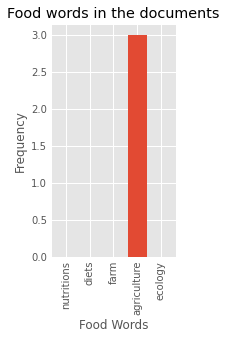

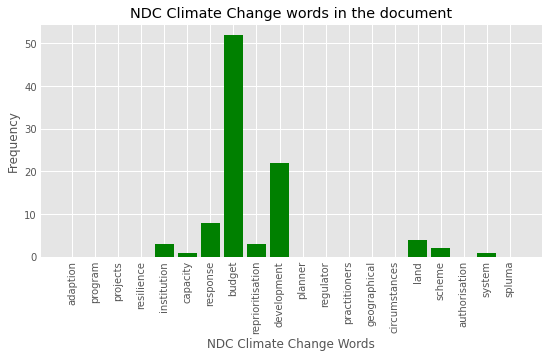

In [20]:
#just to test - need to modularise/make more reproducible and tailor output to be useful across documents
#could also link this back to the df of the documents to output a table with some summary metrics for keywords 
#in eaach document of interest

import matplotlib.pyplot as plt
plt.style.use('ggplot')

x = food
y = food_scores
x_pos = [i for i, _ in enumerate(x)]

plt.rcParams["figure.figsize"] = (2,4)
plt.bar(x, y)
plt.xlabel("Food Words")
plt.ylabel("Frequency")
plt.title("Food words in the documents")
plt.xticks(x_pos, x, rotation=90)
plt.show()

x = ndc_climate_change
y = ndc_climate_change_scores
x_pos = [i for i, _ in enumerate(x)]

plt.rcParams["figure.figsize"] = (8,4)
plt.bar(x, y, color='green') 
plt.xlabel("NDC Climate Change Words")
plt.ylabel("Frequency")
plt.title("NDC Climate Change words in the document")
plt.xticks(x_pos, x, rotation=90)
plt.show()

### Parts of speech tagging

In [21]:
for token in filtered_tokens[:50]:
    print(token, token.tag_, token.pos_, spacy.explain(token.tag_))
print('\n')
    
nouns = []
adjectives = []
for token in filtered_tokens:
    if token.pos_ == 'NOUN':
        nouns.append(token)
    if token.pos_ == 'ADJ':
        adjectives.append(token)

print('some nouns spacy called in the document include:', '\n', nouns[:50], '\n')
print('some adjectives spacy called in the document include:', '\n', adjectives[:50])

oo UH INTJ interjection
official JJ ADJ adjective (English), other noun-modifier (Chinese)
newspaper NN NOUN noun, singular or mass
parliament NNP PROPN noun, proper singular
republic NNP PROPN noun, proper singular
south NNP PROPN noun, proper singular
africa NNP PROPN noun, proper singular
special NNP PROPN noun, proper singular
budget NNP PROPN noun, proper singular
edition NN NOUN noun, singular or mass
imsess NN NOUN noun, singular or mass
© NNP PROPN noun, proper singular
parliament NNP PROPN noun, proper singular
republic NNP PROPN noun, proper singular
south NNP PROPN noun, proper singular
africa NNP PROPN noun, proper singular
follow VBP VERB verb, non-3rd person singular present
commitment NN NOUN noun, singular or mass
make VBP VERB verb, non-3rd person singular present
future JJ ADJ adjective (English), other noun-modifier (Chinese)
work NN NOUN noun, singular or mass
well UH INTJ interjection
zee UH INTJ interjection
insession NN NOUN noun, singular or mass
news NN NOUN no